In [272]:
#import face_recognition as fr
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import pandas as pd
import cv2
face_cascade = cv2.CascadeClassifier('gui_2/assets/haarcascade_frontalface_default.xml')
HEIGHT, WIDTH =48,48
other_emotions =  ['sadness', 'fear', 'anger', 'disgust']
initial_emotions = ['happiness', 'surprise', 'neutral']

In [273]:
paths = ["data/CK_cut/"]#["data/all/train/","data/all/test/"] #["data/CK+/","data/fer/train/"]
# data  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs = []
state = []

## Datos para entrenar emociones iniciales

In [238]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
            
            if item in initial_emotions:
                state.extend([item for p in listdir(f"{path}{item}")])
            else:
                state.extend(["other" for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness


## Datos para entrenar resto emociones 

In [274]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            if item in other_emotions:
                imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
                state.extend([item for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness


In [275]:
len(imgs),len(state)

(183, 183)

In [276]:
errs = []
try:
    imgs_ = []
    for p in imgs:
        temp = Image.open(p)
        save = temp.copy()
        imgs_.append(save)
        temp.close()
except:
    errs.append(p)

In [277]:
imgs_array = []
HEIGHT, WIDTH =48,48
for f in imgs_:
    img = f.convert("L").resize((HEIGHT, WIDTH))
    imgs_array.append(np.array(img))

In [278]:
imgs_array = [el/255 for el in imgs_array]
imgs_array = np.array(imgs_array)

In [279]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

In [280]:
imgs_array.shape

(183, 48, 48, 1)

## Con este modo de cargar imagenes, filtramos caras con cv2

In [289]:
def get_emotion(x,initial):
    if initial:
        if x in initial_emotions:
            return x
        else:
            return "other"
    else: 
        if x in other_emotions:
            return x
        else:
            return "other" 

In [107]:

imgs = []
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            imgs.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])

In [109]:
imgs_ = []
state = []
for p in imgs:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.1, 5) #1.1 factor scale, cuanto  disminuye imagen entre pasos
                                                        #5 MIN nEIGHBORS cuantos vecinos cada posible 
                                                        # rectangulo considerar para prediccion
                                                        # (valor minimo px de la cara detectada)
                                                        # (valor maximo px)
            
    if len(faces)==1:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_.append(recortada)
            state.append(p["emotion"])
    
        
imgs_ = [el/255 for el in imgs_]
imgs_array = np.array(imgs_)


In [110]:
imgs_array.shape

(22087, 48, 48)

In [122]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

# Preparamos entrenamiento

In [281]:
y=pd.DataFrame(state)
y_dummies = pd.get_dummies(y)

In [282]:
y_dummies

,0_anger,0_disgust,0_fear,0_sadness
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
178,0,0,0,1
179,0,0,0,1
180,0,0,0,1
181,0,0,0,1


In [283]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs_array,y_dummies)

In [284]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,BatchNormalization,Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adamax
import keras

In [285]:
# opt = Adam(learning_rate=0.001)

In [286]:
model = Sequential()
# 1-conv
model.add(Conv2D(64,(3,3),padding='same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2-conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4,activation='softmax'))

opt = Adam(learning_rate=0.0005)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()


In [287]:
from keras.models import Sequential, load_model, model_from_json
from keras import callbacks, optimizers
import tensorflow as tf
from datetime import date

fecha=str(date.today().year)+str(date.today().month)+str(date.today().day)    
symbol = 'other_emotions'
h5 = symbol + '_CK_' + fecha + '_v1[hap-neu-sur].h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                       monitor='loss',
                                       verbose=0,
                                       save_best_only=True,
                                       #save_weights_only=True,
                                       mode='auto',
                                       save_freq=1)
callback = [checkpoint]

modelo = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 5000,callbacks = callback,validation_split = 0.1)

Epoch 1/5000
4/4 [==============================] - 1s 220ms/step - loss: 1.6574 - accuracy: 0.2602 - val_loss: 1.3847 - val_accuracy: 0.4286
Epoch 2/5000
4/4 [==============================] - 0s 82ms/step - loss: 1.5888 - accuracy: 0.3577 - val_loss: 1.3854 - val_accuracy: 0.0000e+00
Epoch 3/5000
4/4 [==============================] - 0s 150ms/step - loss: 1.4899 - accuracy: 0.3821 - val_loss: 1.3963 - val_accuracy: 0.0000e+00
Epoch 4/5000
4/4 [==============================] - 1s 215ms/step - loss: 1.3773 - accuracy: 0.4390 - val_loss: 1.3849 - val_accuracy: 0.0000e+00
Epoch 5/5000
4/4 [==============================] - 0s 81ms/step - loss: 1.2563 - accuracy: 0.4634 - val_loss: 1.3618 - val_accuracy: 0.1429
Epoch 6/5000
4/4 [==============================] - 0s 82ms/step - loss: 1.2929 - accuracy: 0.4715 - val_loss: 1.3628 - val_accuracy: 0.0714
Epoch 7/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.2660 - accuracy: 0.5203 - val_loss: 1.3936 - val_accuracy: 0.000

Epoch 58/5000
4/4 [==============================] - 0s 76ms/step - loss: 0.0914 - accuracy: 0.9756 - val_loss: 3.2243 - val_accuracy: 0.4286
Epoch 59/5000
4/4 [==============================] - 0s 135ms/step - loss: 0.0500 - accuracy: 0.9837 - val_loss: 3.0806 - val_accuracy: 0.4286
Epoch 60/5000
4/4 [==============================] - 0s 14ms/step - loss: 0.0728 - accuracy: 0.9675 - val_loss: 2.9870 - val_accuracy: 0.4286
Epoch 61/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0928 - accuracy: 0.9756 - val_loss: 2.9956 - val_accuracy: 0.2857
Epoch 62/5000
4/4 [==============================] - 0s 144ms/step - loss: 0.0724 - accuracy: 0.9837 - val_loss: 3.1418 - val_accuracy: 0.1429
Epoch 63/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0851 - accuracy: 0.9756 - val_loss: 3.4075 - val_accuracy: 0.1429
Epoch 64/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0531 - accuracy: 0.9919 - val_loss: 3.5756 - val_accuracy: 0.0714
Epoc

4/4 [==============================] - 0s 16ms/step - loss: 0.0826 - accuracy: 0.9756 - val_loss: 3.9275 - val_accuracy: 0.2143
Epoch 116/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0335 - accuracy: 0.9837 - val_loss: 3.7768 - val_accuracy: 0.2143
Epoch 117/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 3.4442 - val_accuracy: 0.3571
Epoch 118/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 3.1908 - val_accuracy: 0.3571
Epoch 119/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 3.0071 - val_accuracy: 0.3571
Epoch 120/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0422 - accuracy: 0.9837 - val_loss: 2.8667 - val_accuracy: 0.3571
Epoch 121/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.7889 - val_accuracy: 0.2857
Epoch 122/5000

4/4 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.5712 - val_accuracy: 0.6429
Epoch 173/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0209 - accuracy: 0.9919 - val_loss: 1.4035 - val_accuracy: 0.7143
Epoch 174/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 1.2751 - val_accuracy: 0.7143
Epoch 175/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.1941 - val_accuracy: 0.7143
Epoch 176/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.1521 - val_accuracy: 0.6429
Epoch 177/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.1509 - val_accuracy: 0.7143
Epoch 178/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.1875 - val_accuracy: 0.7857
Epoch 179/5000

4/4 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.9581 - val_accuracy: 0.6429
Epoch 230/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 2.8080 - val_accuracy: 0.5714
Epoch 231/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.6855 - val_accuracy: 0.5714
Epoch 232/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 2.5095 - val_accuracy: 0.5714
Epoch 233/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.9919 - val_loss: 2.2550 - val_accuracy: 0.6429
Epoch 234/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.3359 - val_accuracy: 0.7143
Epoch 235/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0596 - accuracy: 0.9837 - val_loss: 1.9292 - val_accuracy: 0.6429
Epoch 236/5000

4/4 [==============================] - 0s 15ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0260 - val_accuracy: 0.5714
Epoch 287/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.8822 - val_accuracy: 0.6429
Epoch 288/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.7837 - val_accuracy: 0.6429
Epoch 289/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.7385 - val_accuracy: 0.6429
Epoch 290/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.7852 - val_accuracy: 0.6429
Epoch 291/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.8388 - val_accuracy: 0.6429
Epoch 292/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.8755 - val_accuracy: 0.5714
Epoch 293/5000

4/4 [==============================] - 0s 16ms/step - loss: 0.0103 - accuracy: 0.9919 - val_loss: 2.2695 - val_accuracy: 0.6429
Epoch 344/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 2.1088 - val_accuracy: 0.6429
Epoch 345/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.1277 - val_accuracy: 0.7143
Epoch 346/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 2.2314 - val_accuracy: 0.6429
Epoch 347/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.3175 - val_accuracy: 0.6429
Epoch 348/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 2.2693 - val_accuracy: 0.6429
Epoch 349/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.2449 - val_accuracy: 0.5714
Epoch 350/5000

4/4 [==============================] - 0s 15ms/step - loss: 1.6572e-04 - accuracy: 1.0000 - val_loss: 1.9112 - val_accuracy: 0.5000
Epoch 401/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.3980e-04 - accuracy: 1.0000 - val_loss: 1.8993 - val_accuracy: 0.5000
Epoch 402/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.7867 - val_accuracy: 0.5000
Epoch 403/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.7638 - val_accuracy: 0.5714
Epoch 404/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.9471e-04 - accuracy: 1.0000 - val_loss: 1.7770 - val_accuracy: 0.5714
Epoch 405/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.6791e-04 - accuracy: 1.0000 - val_loss: 1.7719 - val_accuracy: 0.5714
Epoch 406/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.7540 - val_accuracy: 0.571

4/4 [==============================] - 0s 15ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.5757 - val_accuracy: 0.7143
Epoch 458/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.4245e-04 - accuracy: 1.0000 - val_loss: 1.7490 - val_accuracy: 0.7857
Epoch 459/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 2.0659 - val_accuracy: 0.6429
Epoch 460/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.4485e-04 - accuracy: 1.0000 - val_loss: 2.8819 - val_accuracy: 0.4286
Epoch 461/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.8343e-04 - accuracy: 1.0000 - val_loss: 3.6777 - val_accuracy: 0.4286
Epoch 462/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 4.1176 - val_accuracy: 0.3571
Epoch 463/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0457 - accuracy: 0.9756 - val_loss: 4.5419 - val_accuracy: 0.4286
Ep

Epoch 514/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.8453 - val_accuracy: 0.7143
Epoch 515/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.7014 - val_accuracy: 0.7143
Epoch 516/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.6375 - val_accuracy: 0.7857
Epoch 517/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.8806e-04 - accuracy: 1.0000 - val_loss: 1.6152 - val_accuracy: 0.7857
Epoch 518/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.6048 - val_accuracy: 0.7857
Epoch 519/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.6687 - val_accuracy: 0.7857
Epoch 520/5000
4/4 [==============================] - 0s 74ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.8027 - val_accuracy: 0.

Epoch 571/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0204 - accuracy: 0.9919 - val_loss: 2.4374 - val_accuracy: 0.6429
Epoch 572/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0069 - accuracy: 0.9919 - val_loss: 2.7102 - val_accuracy: 0.6429
Epoch 573/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0130 - accuracy: 0.9919 - val_loss: 3.0586 - val_accuracy: 0.5000
Epoch 574/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 3.2076 - val_accuracy: 0.5714
Epoch 575/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0359 - accuracy: 0.9919 - val_loss: 3.8237 - val_accuracy: 0.5000
Epoch 576/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 4.2101 - val_accuracy: 0.3571
Epoch 577/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0187 - accuracy: 0.9919 - val_loss: 3.8906 - val_accuracy: 0.4286

Epoch 628/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.2050 - val_accuracy: 0.6429
Epoch 629/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.2129 - val_accuracy: 0.6429
Epoch 630/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.0429e-04 - accuracy: 1.0000 - val_loss: 2.2043 - val_accuracy: 0.6429
Epoch 631/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.0593e-04 - accuracy: 1.0000 - val_loss: 2.2137 - val_accuracy: 0.6429
Epoch 632/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.1557e-04 - accuracy: 1.0000 - val_loss: 2.2307 - val_accuracy: 0.6429
Epoch 633/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.2595 - val_accuracy: 0.6429
Epoch 634/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4742e-04 - accuracy: 1.0000 - val_loss: 2.2786 - val_

4/4 [==============================] - 0s 15ms/step - loss: 4.0598e-04 - accuracy: 1.0000 - val_loss: 2.1966 - val_accuracy: 0.5714
Epoch 685/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.8904e-04 - accuracy: 1.0000 - val_loss: 2.1704 - val_accuracy: 0.5714
Epoch 686/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.2163e-04 - accuracy: 1.0000 - val_loss: 2.1570 - val_accuracy: 0.5714
Epoch 687/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9593e-04 - accuracy: 1.0000 - val_loss: 2.1458 - val_accuracy: 0.5714
Epoch 688/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.0228e-04 - accuracy: 1.0000 - val_loss: 2.1364 - val_accuracy: 0.5714
Epoch 689/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 2.4708 - val_accuracy: 0.5000
Epoch 690/5000
4/4 [==============================] - 0s 14ms/step - loss: 1.6744e-04 - accuracy: 1.0000 - val_loss: 2.7791 - val_accurac

4/4 [==============================] - 0s 16ms/step - loss: 8.7844e-05 - accuracy: 1.0000 - val_loss: 1.6250 - val_accuracy: 0.6429
Epoch 741/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.4124e-04 - accuracy: 1.0000 - val_loss: 1.5694 - val_accuracy: 0.6429
Epoch 742/5000
4/4 [==============================] - 0s 17ms/step - loss: 4.7401e-04 - accuracy: 1.0000 - val_loss: 1.5259 - val_accuracy: 0.6429
Epoch 743/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.0824e-05 - accuracy: 1.0000 - val_loss: 1.4900 - val_accuracy: 0.6429
Epoch 744/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.6093e-04 - accuracy: 1.0000 - val_loss: 1.4618 - val_accuracy: 0.6429
Epoch 745/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.2107e-05 - accuracy: 1.0000 - val_loss: 1.4440 - val_accuracy: 0.6429
Epoch 746/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0712e-04 - accuracy: 1.0000 - val_loss: 1.4278 - val_acc

4/4 [==============================] - 0s 16ms/step - loss: 1.4994e-04 - accuracy: 1.0000 - val_loss: 1.9800 - val_accuracy: 0.5714
Epoch 797/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.1752 - val_accuracy: 0.5714
Epoch 798/5000
4/4 [==============================] - 0s 17ms/step - loss: 8.4687e-04 - accuracy: 1.0000 - val_loss: 2.3501 - val_accuracy: 0.5714
Epoch 799/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.4009 - val_accuracy: 0.5714
Epoch 800/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.3228 - val_accuracy: 0.5714
Epoch 801/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.8362e-05 - accuracy: 1.0000 - val_loss: 2.2074 - val_accuracy: 0.6429
Epoch 802/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.7787e-04 - accuracy: 1.0000 - val_loss: 2.1491 - val_accuracy: 0.642

4/4 [==============================] - 0s 15ms/step - loss: 5.8265e-05 - accuracy: 1.0000 - val_loss: 1.7338 - val_accuracy: 0.7143
Epoch 853/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.3150e-05 - accuracy: 1.0000 - val_loss: 1.7220 - val_accuracy: 0.7143
Epoch 854/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.9054e-05 - accuracy: 1.0000 - val_loss: 1.7179 - val_accuracy: 0.7143
Epoch 855/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1962e-05 - accuracy: 1.0000 - val_loss: 1.7197 - val_accuracy: 0.7143
Epoch 856/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.2237e-04 - accuracy: 1.0000 - val_loss: 1.7274 - val_accuracy: 0.7143
Epoch 857/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.4200e-04 - accuracy: 1.0000 - val_loss: 1.7744 - val_accuracy: 0.7143
Epoch 858/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.6912e-05 - accuracy: 1.0000 - val_loss: 1.8125 - val_acc

Epoch 908/5000
4/4 [==============================] - 0s 78ms/step - loss: 2.9191e-04 - accuracy: 1.0000 - val_loss: 1.9954 - val_accuracy: 0.6429
Epoch 909/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.2210e-04 - accuracy: 1.0000 - val_loss: 1.9998 - val_accuracy: 0.6429
Epoch 910/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.3059e-04 - accuracy: 1.0000 - val_loss: 1.9907 - val_accuracy: 0.6429
Epoch 911/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.6179e-04 - accuracy: 1.0000 - val_loss: 1.9751 - val_accuracy: 0.6429
Epoch 912/5000
4/4 [==============================] - 0s 17ms/step - loss: 6.4591e-05 - accuracy: 1.0000 - val_loss: 1.9627 - val_accuracy: 0.6429
Epoch 913/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.1385e-05 - accuracy: 1.0000 - val_loss: 1.9578 - val_accuracy: 0.6429
Epoch 914/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.5014e-04 - accuracy: 1.0000 - val_loss: 1

Epoch 964/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.8893e-05 - accuracy: 1.0000 - val_loss: 1.9909 - val_accuracy: 0.7143
Epoch 965/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.0246e-05 - accuracy: 1.0000 - val_loss: 1.9854 - val_accuracy: 0.7143
Epoch 966/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0952e-05 - accuracy: 1.0000 - val_loss: 1.9759 - val_accuracy: 0.7143
Epoch 967/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.5459e-04 - accuracy: 1.0000 - val_loss: 1.9497 - val_accuracy: 0.7143
Epoch 968/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9059e-04 - accuracy: 1.0000 - val_loss: 1.9348 - val_accuracy: 0.7143
Epoch 969/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.1901e-05 - accuracy: 1.0000 - val_loss: 1.9317 - val_accuracy: 0.6429
Epoch 970/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1526e-04 - accuracy: 1.0000 - val_loss: 1

Epoch 1020/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0709 - accuracy: 0.9837 - val_loss: 1.0629 - val_accuracy: 0.6429
Epoch 1021/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0410 - accuracy: 0.9837 - val_loss: 0.5095 - val_accuracy: 0.8571
Epoch 1022/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0350 - accuracy: 0.9837 - val_loss: 1.7181 - val_accuracy: 0.7143
Epoch 1023/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0569 - accuracy: 0.9837 - val_loss: 3.9721 - val_accuracy: 0.4286
Epoch 1024/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.2011 - accuracy: 0.9675 - val_loss: 2.1912 - val_accuracy: 0.6429
Epoch 1025/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0363 - accuracy: 0.9919 - val_loss: 1.3726 - val_accuracy: 0.5000
Epoch 1026/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0439 - accuracy: 0.9756 - val_loss: 2.5483 - val_accuracy:

Epoch 1077/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.7363 - val_accuracy: 0.5000
Epoch 1078/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 2.4250 - val_accuracy: 0.5714
Epoch 1079/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.1904 - val_accuracy: 0.5714
Epoch 1080/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0118 - accuracy: 0.9919 - val_loss: 2.0204 - val_accuracy: 0.6429
Epoch 1081/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.5970e-04 - accuracy: 1.0000 - val_loss: 2.0484 - val_accuracy: 0.6429
Epoch 1082/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.5392e-04 - accuracy: 1.0000 - val_loss: 2.1041 - val_accuracy: 0.5714
Epoch 1083/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.1962 - val_a

4/4 [==============================] - 0s 15ms/step - loss: 2.6857e-04 - accuracy: 1.0000 - val_loss: 1.9901 - val_accuracy: 0.6429
Epoch 1134/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0102 - accuracy: 0.9919 - val_loss: 2.1689 - val_accuracy: 0.5714
Epoch 1135/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0419 - accuracy: 0.9756 - val_loss: 3.9711 - val_accuracy: 0.5000
Epoch 1136/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.0084 - accuracy: 0.9919 - val_loss: 5.4489 - val_accuracy: 0.5000
Epoch 1137/5000
4/4 [==============================] - 0s 17ms/step - loss: 7.2627e-04 - accuracy: 1.0000 - val_loss: 5.8436 - val_accuracy: 0.5000
Epoch 1138/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.9885 - val_accuracy: 0.5000
Epoch 1139/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0211 - accuracy: 0.9919 - val_loss: 5.5259 - val_accuracy: 0.5000


4/4 [==============================] - 0s 17ms/step - loss: 7.0496e-05 - accuracy: 1.0000 - val_loss: 3.7620 - val_accuracy: 0.5714
Epoch 1190/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0178 - accuracy: 0.9919 - val_loss: 3.8177 - val_accuracy: 0.5714
Epoch 1191/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.2377e-04 - accuracy: 1.0000 - val_loss: 3.8469 - val_accuracy: 0.5714
Epoch 1192/5000
4/4 [==============================] - 0s 17ms/step - loss: 1.3092e-04 - accuracy: 1.0000 - val_loss: 3.8348 - val_accuracy: 0.5714
Epoch 1193/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.8121 - val_accuracy: 0.5000
Epoch 1194/5000
4/4 [==============================] - 0s 18ms/step - loss: 1.5359e-04 - accuracy: 1.0000 - val_loss: 3.7771 - val_accuracy: 0.5000
Epoch 1195/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.4525e-04 - accuracy: 1.0000 - val_loss: 3.7805 - val_accur

Epoch 1245/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9315e-05 - accuracy: 1.0000 - val_loss: 2.8847 - val_accuracy: 0.5714
Epoch 1246/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.8674 - val_accuracy: 0.5714
Epoch 1247/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.9002e-05 - accuracy: 1.0000 - val_loss: 2.8506 - val_accuracy: 0.5714
Epoch 1248/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.8299 - val_accuracy: 0.5714
Epoch 1249/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.0166e-04 - accuracy: 1.0000 - val_loss: 2.8161 - val_accuracy: 0.5714
Epoch 1250/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.0916e-05 - accuracy: 1.0000 - val_loss: 2.8062 - val_accuracy: 0.5714
Epoch 1251/5000
4/4 [==============================] - 0s 15ms/step - loss: 8.9845e-05 - accuracy: 1.0000 - val_loss: 2.

4/4 [==============================] - 0s 15ms/step - loss: 9.7727e-05 - accuracy: 1.0000 - val_loss: 3.0543 - val_accuracy: 0.5714
Epoch 1301/5000
4/4 [==============================] - 0s 15ms/step - loss: 9.9312e-05 - accuracy: 1.0000 - val_loss: 3.0544 - val_accuracy: 0.5714
Epoch 1302/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.4446e-04 - accuracy: 1.0000 - val_loss: 3.0662 - val_accuracy: 0.5714
Epoch 1303/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9570e-04 - accuracy: 1.0000 - val_loss: 3.0681 - val_accuracy: 0.5714
Epoch 1304/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.8558e-04 - accuracy: 1.0000 - val_loss: 3.0655 - val_accuracy: 0.5714
Epoch 1305/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0682e-04 - accuracy: 1.0000 - val_loss: 3.0609 - val_accuracy: 0.5714
Epoch 1306/5000
4/4 [==============================] - 0s 14ms/step - loss: 3.1625e-05 - accuracy: 1.0000 - val_loss: 3.0610 - v

4/4 [==============================] - 0s 15ms/step - loss: 1.3829e-04 - accuracy: 1.0000 - val_loss: 3.1534 - val_accuracy: 0.5714
Epoch 1356/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.2376e-05 - accuracy: 1.0000 - val_loss: 3.1596 - val_accuracy: 0.5714
Epoch 1357/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.2921e-05 - accuracy: 1.0000 - val_loss: 3.1562 - val_accuracy: 0.5714
Epoch 1358/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.1404e-05 - accuracy: 1.0000 - val_loss: 3.1535 - val_accuracy: 0.5714
Epoch 1359/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.1725e-05 - accuracy: 1.0000 - val_loss: 3.1484 - val_accuracy: 0.5714
Epoch 1360/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.3189e-05 - accuracy: 1.0000 - val_loss: 3.1417 - val_accuracy: 0.5714
Epoch 1361/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.4543e-05 - accuracy: 1.0000 - val_loss: 3.1331 - v

4/4 [==============================] - 0s 15ms/step - loss: 5.5266e-05 - accuracy: 1.0000 - val_loss: 2.6589 - val_accuracy: 0.5714
Epoch 1411/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.4072e-04 - accuracy: 1.0000 - val_loss: 2.6741 - val_accuracy: 0.5714
Epoch 1412/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.3169e-05 - accuracy: 1.0000 - val_loss: 2.6803 - val_accuracy: 0.5714
Epoch 1413/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.7000e-04 - accuracy: 1.0000 - val_loss: 2.6778 - val_accuracy: 0.5714
Epoch 1414/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.3330e-05 - accuracy: 1.0000 - val_loss: 2.6707 - val_accuracy: 0.5714
Epoch 1415/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.1927e-05 - accuracy: 1.0000 - val_loss: 2.6697 - val_accuracy: 0.5714
Epoch 1416/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.2461e-04 - accuracy: 1.0000 - val_loss: 2.6730 - v

4/4 [==============================] - 0s 15ms/step - loss: 5.9268e-05 - accuracy: 1.0000 - val_loss: 2.5204 - val_accuracy: 0.6429
Epoch 1466/5000
4/4 [==============================] - 0s 16ms/step - loss: 5.2757e-05 - accuracy: 1.0000 - val_loss: 2.5250 - val_accuracy: 0.6429
Epoch 1467/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.2262e-05 - accuracy: 1.0000 - val_loss: 2.5331 - val_accuracy: 0.6429
Epoch 1468/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9529e-05 - accuracy: 1.0000 - val_loss: 2.5340 - val_accuracy: 0.6429
Epoch 1469/5000
4/4 [==============================] - 0s 18ms/step - loss: 3.9238e-05 - accuracy: 1.0000 - val_loss: 2.5409 - val_accuracy: 0.6429
Epoch 1470/5000
4/4 [==============================] - 0s 17ms/step - loss: 2.5178e-04 - accuracy: 1.0000 - val_loss: 2.5537 - val_accuracy: 0.5714
Epoch 1471/5000
4/4 [==============================] - 0s 18ms/step - loss: 5.5434e-06 - accuracy: 1.0000 - val_loss: 2.5523 - v

4/4 [==============================] - 0s 16ms/step - loss: 6.1621e-05 - accuracy: 1.0000 - val_loss: 2.7113 - val_accuracy: 0.5714
Epoch 1521/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.9053e-05 - accuracy: 1.0000 - val_loss: 2.6996 - val_accuracy: 0.5714
Epoch 1522/5000
4/4 [==============================] - 0s 16ms/step - loss: 8.2915e-05 - accuracy: 1.0000 - val_loss: 2.6998 - val_accuracy: 0.5714
Epoch 1523/5000
4/4 [==============================] - 0s 18ms/step - loss: 2.1347e-05 - accuracy: 1.0000 - val_loss: 2.7178 - val_accuracy: 0.5714
Epoch 1524/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.3944e-05 - accuracy: 1.0000 - val_loss: 2.7295 - val_accuracy: 0.5714
Epoch 1525/5000
4/4 [==============================] - 0s 17ms/step - loss: 3.0305e-05 - accuracy: 1.0000 - val_loss: 2.7288 - val_accuracy: 0.5714
Epoch 1526/5000
4/4 [==============================] - 0s 16ms/step - loss: 3.9519e-05 - accuracy: 1.0000 - val_loss: 2.7195 - v

4/4 [==============================] - 0s 16ms/step - loss: 2.6035e-05 - accuracy: 1.0000 - val_loss: 2.6350 - val_accuracy: 0.5714
Epoch 1576/5000
4/4 [==============================] - 0s 16ms/step - loss: 9.4846e-06 - accuracy: 1.0000 - val_loss: 2.6350 - val_accuracy: 0.5714
Epoch 1577/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.4291e-05 - accuracy: 1.0000 - val_loss: 2.6313 - val_accuracy: 0.5714
Epoch 1578/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.0641e-04 - accuracy: 1.0000 - val_loss: 2.6291 - val_accuracy: 0.5714
Epoch 1579/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.8649e-06 - accuracy: 1.0000 - val_loss: 2.6300 - val_accuracy: 0.5714
Epoch 1580/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.8366 - val_accuracy: 0.5714
Epoch 1581/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.4355e-05 - accuracy: 1.0000 - val_loss: 2.9652 - val_a

4/4 [==============================] - 0s 16ms/step - loss: 9.9951e-06 - accuracy: 1.0000 - val_loss: 2.4025 - val_accuracy: 0.5714
Epoch 1631/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.0038e-06 - accuracy: 1.0000 - val_loss: 2.4013 - val_accuracy: 0.5714
Epoch 1632/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.0919e-06 - accuracy: 1.0000 - val_loss: 2.4055 - val_accuracy: 0.5714
Epoch 1633/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.1812e-05 - accuracy: 1.0000 - val_loss: 2.3988 - val_accuracy: 0.5714
Epoch 1634/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1841e-04 - accuracy: 1.0000 - val_loss: 2.3987 - val_accuracy: 0.5714
Epoch 1635/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.9662e-05 - accuracy: 1.0000 - val_loss: 2.3924 - val_accuracy: 0.5714
Epoch 1636/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.2941e-05 - accuracy: 1.0000 - val_loss: 2.3856 - v

Epoch 1686/5000
4/4 [==============================] - 0s 14ms/step - loss: 0.0136 - accuracy: 0.9919 - val_loss: 11.5989 - val_accuracy: 0.3571
Epoch 1687/5000
4/4 [==============================] - 0s 16ms/step - loss: 0.0643 - accuracy: 0.9919 - val_loss: 10.9957 - val_accuracy: 0.3571
Epoch 1688/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0246 - accuracy: 0.9837 - val_loss: 8.7116 - val_accuracy: 0.3571
Epoch 1689/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 7.0324 - val_accuracy: 0.3571
Epoch 1690/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0847 - accuracy: 0.9675 - val_loss: 7.4038 - val_accuracy: 0.2857
Epoch 1691/5000
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 8.1547 - val_accuracy: 0.2143
Epoch 1692/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.1016 - accuracy: 0.9837 - val_loss: 7.3583 - val_accurac

4/4 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.8678 - val_accuracy: 0.6429
Epoch 1743/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.3675e-04 - accuracy: 1.0000 - val_loss: 1.8778 - val_accuracy: 0.6429
Epoch 1744/5000
4/4 [==============================] - 0s 17ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.9042 - val_accuracy: 0.6429
Epoch 1745/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.9657 - val_accuracy: 0.6429
Epoch 1746/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.4257e-04 - accuracy: 1.0000 - val_loss: 2.0284 - val_accuracy: 0.7143
Epoch 1747/5000
4/4 [==============================] - 0s 16ms/step - loss: 7.7021e-04 - accuracy: 1.0000 - val_loss: 2.0881 - val_accuracy: 0.7143
Epoch 1748/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.3034e-04 - accuracy: 1.0000 - val_loss: 2.1478 - val_accuracy:

Epoch 1798/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.8126e-04 - accuracy: 1.0000 - val_loss: 2.4073 - val_accuracy: 0.5000
Epoch 1799/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.3266e-04 - accuracy: 1.0000 - val_loss: 2.3957 - val_accuracy: 0.5000
Epoch 1800/5000
4/4 [==============================] - 0s 15ms/step - loss: 3.0667e-04 - accuracy: 1.0000 - val_loss: 2.3902 - val_accuracy: 0.5000
Epoch 1801/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.9612e-04 - accuracy: 1.0000 - val_loss: 2.3859 - val_accuracy: 0.5000
Epoch 1802/5000
4/4 [==============================] - 0s 16ms/step - loss: 1.4995e-04 - accuracy: 1.0000 - val_loss: 2.3707 - val_accuracy: 0.5000
Epoch 1803/5000
4/4 [==============================] - 0s 16ms/step - loss: 4.9214e-05 - accuracy: 1.0000 - val_loss: 2.3646 - val_accuracy: 0.5000
Epoch 1804/5000
4/4 [==============================] - 0s 15ms/step - loss: 1.1306e-04 - accuracy: 1.0000 - val_

Epoch 1854/5000
4/4 [==============================] - 0s 15ms/step - loss: 2.2879e-04 - accuracy: 1.0000 - val_loss: 3.1542 - val_accuracy: 0.5714
Epoch 1855/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0144 - accuracy: 0.9919 - val_loss: 3.0336 - val_accuracy: 0.5714
Epoch 1856/5000
4/4 [==============================] - 0s 15ms/step - loss: 7.1933e-04 - accuracy: 1.0000 - val_loss: 2.9269 - val_accuracy: 0.5714
Epoch 1857/5000
4/4 [==============================] - 0s 15ms/step - loss: 4.2390e-04 - accuracy: 1.0000 - val_loss: 2.8938 - val_accuracy: 0.5714
Epoch 1858/5000
4/4 [==============================] - 0s 15ms/step - loss: 0.0301 - accuracy: 0.9919 - val_loss: 2.7600 - val_accuracy: 0.5714
Epoch 1859/5000
4/4 [==============================] - 0s 16ms/step - loss: 2.5960e-04 - accuracy: 1.0000 - val_loss: 2.6690 - val_accuracy: 0.5714
Epoch 1860/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.6761e-04 - accuracy: 1.0000 - val_loss: 2.

KeyboardInterrupt: 

In [290]:
paths = ["data/predict/"]
# data_pred  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs_pred = []
state_pred = []
im_pred = {}

In [291]:
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            imgs_pred.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])
            #state_pred.extend([item for p in listdir(f"{path}{item}")])



In [292]:
len(imgs_pred)

73

In [293]:
from keras.models import load_model

In [294]:
#model = load_model('intial_emotions_2_20211116_v1.h5')

In [295]:
imgs_pred_ = []
state_pred = []
for p in imgs_pred:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.1, 5)
    if len(faces)>0:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_pred_.append(recortada)
            state_pred.append(p["emotion"])
    
        
imgs_pred_ = [el/255 for el in imgs_pred_]
imgs_pred_ = np.array(imgs_pred_)
imgs_pred_= imgs_pred_.reshape((len(imgs_pred_),48,48,1))

In [296]:
len(imgs_pred_)

80

In [297]:
len(state_pred)

80

In [298]:
prediction = model.predict(imgs_pred_)

In [299]:
state_pred

['other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness']

In [300]:
prediction[:5]

array([[6.1362679e-04, 2.8141371e-03, 3.6087092e-02, 9.6048510e-01],
       [9.9992158e-06, 9.9765515e-01, 2.3286976e-03, 6.0847829e-06],
       [7.8685559e-02, 2.2171023e-05, 9.1935623e-01, 1.9360287e-03],
       [1.3495557e-07, 4.3298339e-08, 8.5661947e-07, 9.9999905e-01],
       [3.6215902e-10, 3.3039757e-07, 9.9999964e-01, 2.4815122e-08]],
      dtype=float32)

In [301]:
prediction.argmax(axis = -1)


array([3, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 0, 1, 2, 2, 0, 3, 1,
       1, 1, 1, 3, 1, 0, 1, 2, 1, 2, 2, 0, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0,
       3, 3, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 3, 3, 1,
       3, 3, 3, 2, 0, 2, 3, 1, 0, 3, 3, 3, 3, 2])

In [302]:
cats= y_dummies.columns
cats = [x.replace("0_","") for x in cats]

In [303]:
cats = ['anger','disgust', 'fear', 'sadness']

In [304]:
len(prediction)

80

In [305]:
states_model = []
i=0
for i in range(len(prediction)):
    states_model.append(cats[prediction[i].argmax()])
    print(state_pred[i],cats[prediction[i].argmax()])

other sadness
other disgust
other fear
other sadness
other fear
other sadness
other sadness
other sadness
other sadness
other fear
other sadness
other fear
other fear
other sadness
disgust sadness
disgust anger
disgust disgust
disgust fear
disgust fear
disgust anger
disgust sadness
disgust disgust
disgust disgust
disgust disgust
disgust disgust
disgust sadness
disgust disgust
disgust anger
disgust disgust
disgust fear
disgust disgust
disgust fear
disgust fear
anger anger
anger sadness
anger disgust
anger disgust
anger disgust
anger sadness
anger disgust
other disgust
other sadness
other sadness
other anger
other sadness
other sadness
other sadness
other sadness
other sadness
other fear
other anger
other fear
other fear
other fear
other fear
other fear
other fear
other anger
other fear
other disgust
other disgust
other fear
fear fear
fear sadness
fear sadness
fear disgust
fear sadness
fear sadness
fear sadness
fear fear
fear anger
fear fear
fear sadness
sadness disgust
sadness anger
sad

In [306]:
from sklearn.metrics import accuracy_score

In [307]:
accuracy_score(state_pred,states_model)

0.2

In [269]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


In [270]:
conf = confusion_matrix(states_model, state_pred)
conf = pd.DataFrame(conf,columns=cats, index=cats)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

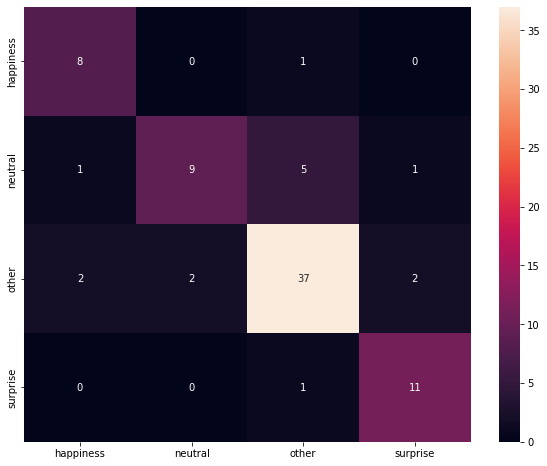

In [271]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(conf, annot=True)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']